## rnn

In [48]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, sequence_lenght):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*sequence_lenght, 1)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, self.hidden_size).to('cuda' if torch.cuda.is_available() else 'cpu')

        out, _ = self.rnn(x, h0)
        out = torch.flatten(out)
        out = self.fc(out)
        return out

## test

In [49]:
print(f'CUDA available: {torch.cuda.is_available()}')

rnn = RNN(input_size=4, hidden_size=32, n_layers=2, sequence_lenght=30).to('cuda' if torch.cuda.is_available() else 'cpu')

x = torch.rand((30, 4)).to('cuda' if torch.cuda.is_available() else 'cpu')
x.to('cuda' if torch.cuda.is_available() else 'cpu')
print(rnn(x).shape)

CUDA available: True
torch.Size([1])


## data

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# https://www.kaggle.com/code/sanmitpatil/delhi-mean-temperature-lstm

data = pd.read_csv('./climate/DailyDelhiClimateTrain.csv')
data = data.drop([1461])
data = data.drop(columns=['date'])

#standarize columns
scaler=MinMaxScaler()
scaler2=MinMaxScaler()
scaler3=MinMaxScaler()
scaler4=MinMaxScaler()

meantemp_scaled = scaler.fit_transform(data[['meantemp']])
humidity_scaled = scaler2.fit_transform(data[['humidity']])
windspeed_scaled = scaler3.fit_transform(data[['wind_speed']])
meanpressure_scaled = scaler4.fit_transform(data[['meanpressure']])
X_scaled = np.concatenate((meantemp_scaled, humidity_scaled, windspeed_scaled, meanpressure_scaled), axis=1)

#batches of 30 days
x=[]
for i in range(X_scaled.shape[0]-30):
    row = X_scaled[i:i+31]
    x.append(row)
x=np.array(x)
X_train = x[:,:-1].astype('float32')
Y_train = x[:,-1,0] .astype('float32')

#hyperparam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-6


optim = torch.optim.Adam(rnn.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.MSELoss()


## train

In [57]:
epochs = 50
losses = []

for epoch in range(epochs):
    for x,y in zip(X_train,Y_train):
        x = torch.from_numpy(x).to(device)
        y = torch.tensor([torch.tensor(y)]).to(device)
        
        #forward
        out = rnn(x)
        loss = criterion(out,y)

        #backward
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.detach().item())

    print(f'Epoch: {epoch}  loss:{loss}')

Epoch: 0  loss:0.005625221878290176
Epoch: 1  loss:0.005585763603448868
Epoch: 2  loss:0.005545720923691988
Epoch: 3  loss:0.005505048204213381
Epoch: 4  loss:0.00546378456056118
Epoch: 5  loss:0.005421922076493502
Epoch: 6  loss:0.005379507318139076
Epoch: 7  loss:0.005336575675755739
Epoch: 8  loss:0.005293143913149834
Epoch: 9  loss:0.005249211564660072
Epoch: 10  loss:0.005204834509640932
Epoch: 11  loss:0.005160011816769838
Epoch: 12  loss:0.00511476956307888
Epoch: 13  loss:0.005069119390100241
Epoch: 14  loss:0.005023167002946138
Epoch: 15  loss:0.0049768853932619095
Epoch: 16  loss:0.004930248949676752
Epoch: 17  loss:0.004883369896560907
Epoch: 18  loss:0.00483621284365654
Epoch: 19  loss:0.0047888061963021755
Epoch: 20  loss:0.00474121468141675
Epoch: 21  loss:0.004693427588790655
Epoch: 22  loss:0.004645488690584898
Epoch: 23  loss:0.0045974161475896835
Epoch: 24  loss:0.004549130797386169
Epoch: 25  loss:0.0045008365996181965
Epoch: 26  loss:0.004452454391866922
Epoch: 27  

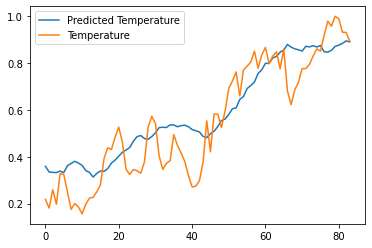

In [59]:
import matplotlib.pyplot as plt

test_data = pd.read_csv('./climate/DailyDelhiClimateTest.csv')

meantemp_scaled1 = scaler.fit_transform(test_data[['meantemp']])
humidity_scaled1 = scaler2.fit_transform(test_data[['humidity']])
windspeed_scaled1 = scaler3.fit_transform(test_data[['wind_speed']])
meanpressure_scaled1 = scaler4.fit_transform(test_data[['meanpressure']])
new_data_scaled = np.concatenate((meantemp_scaled1, humidity_scaled1, windspeed_scaled1, meanpressure_scaled1), axis=1)
x1=[]
for i in range(new_data_scaled.shape[0]-30):
    row = new_data_scaled[i:i+31]
    x1.append(row)
    
x1=np.array(x1)
X_test = x1[:,:-1].astype('float32')
Y_test = x1[:,-1,0].astype('float32')

out = []
for x in X_test:
    x = torch.from_numpy(x).to(device)
    out.append(rnn(x).item())

plt.figure()
plt.plot(out[:], label="Predicted Temperature")
plt.plot(Y_test[:], label="Temperature")
plt.legend()